<a href="https://colab.research.google.com/github/fellipemelhado/python-projects/blob/Machine-Learning-for-Algorithmic-training-by-Stefan-Jansen/CH2_Market_and_Fundamental_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 Market and Fundamental Data
In particular, this chapter will cover the following topics:
- How market microstructure shapes market data
- How to reconstruct the order book from tick data using Nasdaq ITCH
- How to summarize tick data using various types of bars
- How to work with eXtensible Business Reporting Language (XBRL)-encoded
electronic filings
- How to parse and combine market and fundamental data to create a P/E series
- How to access various market and fundamental data sources using Python
---



## Market places
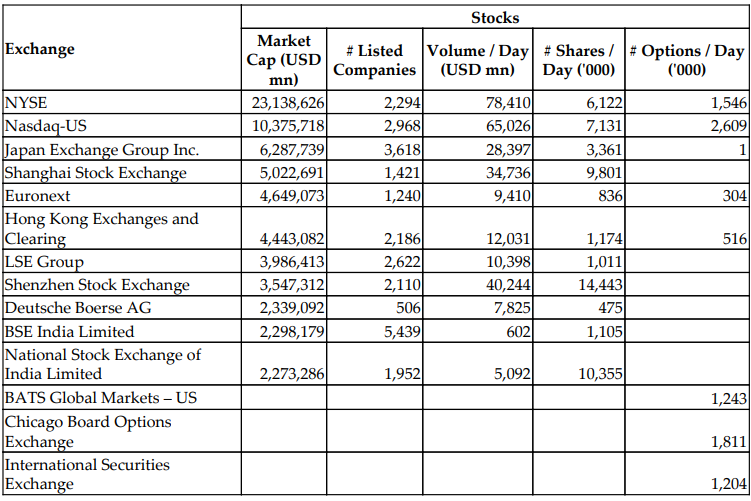




## Working with ITCH
"The
Nasdaq offers a TotalView ITCH direct data-feed protocol that allows subscribers to track
individual orders for equity instruments from placement to execution or cancellation"

In [ ]:
import gzip
import shutil
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
#from clint.textui import progress
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from struct import unpack
from collections import namedtuple, Counter
from datetime import timedelta
from time import time

In [ ]:
# First will set
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

Downloading data from a FTP server provided by the author

In [ ]:
FTP_URL = 'ftp://emi.nasdaq.com/ITCH/Nasdaq_ITCH/'
SOURCE_FILE = '03272019.NASDAQ_ITCH50.gz'

# Defining a function to download, if possible
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    filename = data_path / url.split('/')[-1]
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)
    unzipped = data_path / (filename.stem + '.bin')
    if not (data_path / unzipped).exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    return unzipped



In [ ]:
file_name = may_be_download(urljoin('https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/', SOURCE_FILE))
date = file_name.name.split('.')[0]

Downloading... https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/03272019.NASDAQ_ITCH50.gz
Unzipping to data/03272019.NASDAQ_ITCH50.bin


Creating formatc dictionaires that will be used later

In [ ]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

formats = {
    ('integer', 2): 'H',
    ('integer', 4): 'I',
    ('integer', 6): '6s',
    ('integer', 8): 'Q',
    ('alpha', 1)  : 's',
    ('alpha', 2)  : '2s',
    ('alpha', 4)  : '4s',
    ('alpha', 8)  : '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

Will be defining a massage parser for all ITCH binary data

In [ ]:
#Downloading the message data
message_data = (pd.read_excel('message_types.xlsx', sheet_name='messages')
                .sort_values('id')
                .drop('id', axis=1))

# Cleaing the dataframe
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = df.value.str.strip()
    df.name = (df.name
               .str.strip() # remove whitespace
               .str.lower()
               .str.replace(' ', '_')
               .str.replace('-', '_')
               .str.replace('/', '_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

message_types = clean_message_types(message_data)
message_types.head()

,name,offset,length,value,notes,message_type
0,message_type,0,1,S,System Event Message,S
1,stock_locate,1,2,Integer,Always 0,NaN
2,tracking_number,3,2,Integer,Nasdaq internal tracking number,NaN
3,timestamp,5,6,Integer,Nanoseconds since midnight,NaN
4,event_code,11,1,Alpha,See System Event Codes below,NaN


In [ ]:
# Creating Message Labels
message_labels = (message_types.loc[:, ['message_type', 'notes']] # loc:Access a group of rows and columns by label(s) or a boolean array.
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.head()


,message_type,name
0,S,System Event Message
5,R,Stock Directory Message
23,H,Stock Trading Action Message.
31,Y,Reg SHO Short Sale Price Test Restricted Indic...
37,L,Market Participant Position message


In [ ]:
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
message_labels.head()

<ipython-input-54-ae6ded5b2802>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('.', '')


,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


In [ ]:
message_types.message_type = message_types.message_type.ffill() # ffil: Fill NA/NaN values by propagating the last valid observation to next valid.
message_types = message_types[message_types.name != 'message_type'] #filtering
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))
message_types

<ipython-input-63-1cc97b52b3f8>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('(', '')
<ipython-input-63-1cc97b52b3f8>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace(')', ''))


,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R
...,...,...,...,...,...,...
168,far_price,36,4,price_4,A hypothetical auction-clearing price for cros...,I
169,near_price,40,4,price_4,A hypothetical auction-clearing price for cros...,I
170,current_reference_price,44,4,price_4,The price at which the NOII shares are being c...,I
171,cross_type,48,1,alpha,The type of Nasdaq cross for which the NOII me...,I


Will use parses to translate and simply the message contents, from the formats dicionary

In [ ]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                            .apply(tuple, axis=1).map(formats))
message_types.head()

,name,offset,length,value,notes,message_type,formats
1,stock_locate,1,2,integer,Always 0,S,H
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S,H
3,timestamp,5,6,integer,Nanoseconds since midnight,S,6s
4,event_code,11,1,alpha,See System Event Codes below,S,s
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R,H


In [ ]:
# Formatting details as alphanumerical
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

Generating message classes as tuples

In [ ]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())


# Alphanumeric requires extra work, so will be created a function (format_alpha) to deal with this
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

Processing Binary message, its needed because every day ussualy constains voer 350m messages

In [ ]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if m == 'R':
                dc.append('stock')
            store.append(mtype,
                         data,
                         format='t',
                         min_itemsize=s,
                         data_columns=dc)

messages = {}
message_count = 0
message_type_counter = Counter()

Sumarizing Trading day

In [ ]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)



<ipython-input-83-88ca3cf43e32>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  counter = pd.Series(message_type_counter).to_frame('# Trades')


<class 'pandas.io.pytables.HDFStore'>
File path: data/itch.h5

In [ ]:
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)


<class 'pandas.io.pytables.HDFStore'>
File path: data/itch.h5

In [ ]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)
trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

KeyError: ignored

## API acess to market data

> Indented block

> Indented block




We do this to rebuild an order flow of a single stock for a give day, so we build a function to show how to collect data that affect trading of a certain stock